In [2]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_cvec_uni_a.pkl'
dest_model_file_b = model_folders + 'lda_cvec_uni_b.jlb'
dest_model_file_c = model_folders + 'lda_cvec_uni_c_dill.pkl'

gs_model_bk = './gs_models/cvec_uni.model'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

%matplotlib inline

# Custom
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [3]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [4]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [5]:
# Quickly clean the contexts
corpus = frame['lemma_text'].values

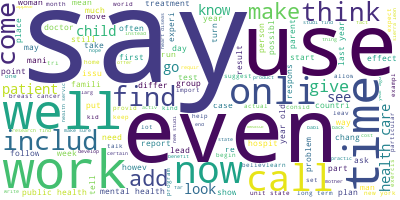

In [6]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:config.TRAIN_SIZE]
TRAIN_SIZE = config.TRAIN_SIZE +1
TEST_SIZE = config.TEST_SIZE + config.TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [8]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(ngram_range=(1, 1),                  
                             analyzer='word',                  # Bi-grams
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,            # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [9]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.0567955302044831 %


In [10]:
# Build LDA Model
lda_model = LDA(n_topics=10,               # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [11]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -47943814.23593922
Perplexity:  1752.391273702036
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 10,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [12]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [30]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 25}
Best Log Likelihood Score:  -12411196.864500992
Model Perplexity:  1877.916148379392


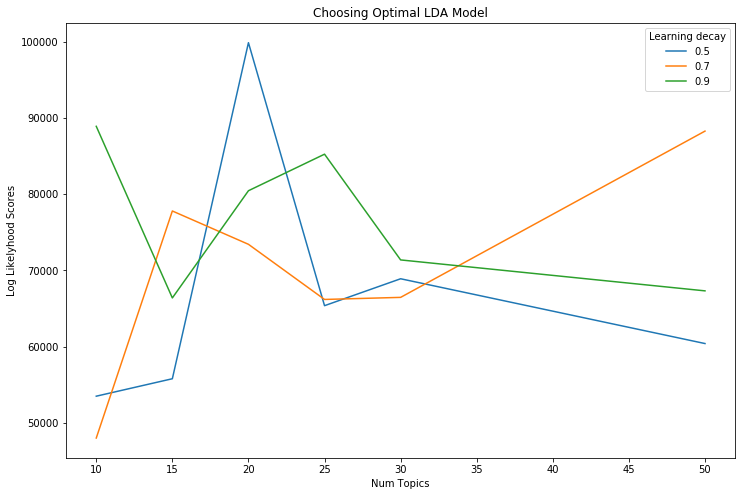

In [31]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = [0.5, 0.7, 0.9]
one_third = len(n_topics)
two_third = one_third*2

gscore = dict(model.cv_results_)
log_likelyhoods_5 = gscore['std_train_score'][0:one_third]
log_likelyhoods_7 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_9 = gscore['std_train_score'][two_third:]

# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### 1. Saving Model to disk

In [42]:
# Have: best_lda_model

## Pickle
##----------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## --------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

['./models/lda_cvec_uni_b.jlb']

In [44]:
# loaded_model = pickle.load(open(dest_model_file_a,'rb')
# loaded_model.score(data_test)
# # print(result)

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(data_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

In [ ]:
df_document_topics.to_csv(dest_files, sep='|',unicode='utf-8')

In [28]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,10,2414
1,12,2030
2,5,1788
3,7,1589
4,14,1343
5,8,1150
6,17,914
7,2,897
8,15,856
9,13,821


In [29]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/shaynenguyen2012/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
10     175.490845   -9.731544       1        1  11.273667
5     -131.603424 -131.076874       2        1   8.727948
7      -42.429714  -95.715553       3        1   8.361123
12     111.861809   49.401730       4        1   7.922246
8       93.958832  -33.788364       5        1   5.644008
11    -159.450943   88.589737       6        1   5.120060
14     108.864914  136.288071       7        1   4.952727
3       36.900848   89.074493       8        1   4.686302
17    -102.120682   30.091415       9        1   4.631594
15      48.411385 -152.553680      10        1   4.507208
0      -80.035889  135.189713      11        1   4.411056
2      -39.482513 -177.021729      12        1   4.079319
13    -183.947739  -14.009587      13        1   3.998496
18       4.479455  166.280334      14        1   3.868599
6     -109.090416  -50.892193      15        1   3.806401
16      28.516554  -71.285698      16        1   3.733699
1      128.319519 -109.798820      17        1   3.389490
4      -35.977219  -16.615049      18        1   2.742895
9       31.494932   11.935486      19        1   2.656830
19     -34.717068   64.806717      20        1   1.486332, topic_info=      Category           Freq        Term          Total  loglift  logprob
4429   Default   14189.000000        drug   14189.000000  30.0000  30.0000
2048   Default   13881.000000      cancer   13881.000000  29.0000  29.0000
10360  Default   30837.000000     patient   30837.000000  28.0000  28.0000
5575   Default   12933.000000        food   12933.000000  27.0000  27.0000
13691  Default   24829.000000       study   24829.000000  26.0000  26.0000
6501   Default   41491.000000      health   41491.000000  25.0000  25.0000
12468  Default  102198.000000         say  102198.000000  24.0000  24.0000
2120   Default   21280.000000        care   21280.000000  23.0000  23.0000
15147  Default    5295.000000     vaccine    5295.000000  22.0000  22.0000
9564   Default    8297.000000         nhs    8297.000000  21.0000  21.0000
15342  Default    7770.000000       virus    7770.000000  20.0000  20.0000
15548  Default    7268.000000      weight    7268.000000  19.0000  19.0000
2430   Default   15559.000000       child   15559.000000  18.0000  18.0000
4532   Default    9000.000000         eat    9000.000000  17.0000  17.0000
11944  Default   14028.000000  researcher   14028.000000  16.0000  16.0000
5257   Default    6603.000000         fat    6603.000000  15.0000  15.0000
15707  Default   15017.000000       woman   15017.000000  14.0000  14.0000
7358   Default    4180.000000   insurance    4180.000000  13.0000  13.0000
2014   Default    6249.000000     calorie    6249.000000  12.0000  12.0000
1141   Default    4852.000000        baby    4852.000000  11.0000  11.0000
2265   Default    5132.000000        cell    5132.000000  10.0000  10.0000
4147   Default   15519.000000     disease   15519.000000   9.0000   9.0000
13776  Default    4735.000000       sugar    4735.000000   8.0000   8.0000
13035  Default    5088.000000       sleep    5088.000000   7.0000   7.0000
15116  Default   22852.000000         use   22852.000000   6.0000   6.0000
6761   Default   16921.000000    hospital   16921.000000   5.0000   5.0000
4283   Default   14772.000000      doctor   14772.000000   4.0000   4.0000
12707  Default    9602.000000     service    9602.000000   3.0000   3.0000
5530   Default    3133.000000         flu    3133.000000   2.0000   2.0000
2040   Default    3998.000000      canada    3998.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
6753   Topic20     105.668571       horse     230.259581   3.4300  -6.5541
7702   Topic20     234.653053        join    1139.431715   2.6287  -5.7563
6078   Topic20     287.195836        goal    1845.868693   2.3483  -5.5542
10587  Topic20     212.958928    pharmacy    1010.879768

In [30]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aafter,aall,aan,aand,aap,aare,aarhus,aaron,aarp,aas,...,zocor,zombie,zone,zoo,zoom,zoonotic,zucchini,zucker,zuckerman,zumba
Topic0,0.05,0.05,0.050000,0.050000,0.05,0.05,0.050000,0.050000,0.05,0.050000,...,0.05,0.05,8.234038,0.050000,0.05,0.05,244.05,0.05,0.050000,0.050000
Topic1,0.05,0.05,4.010535,7.901827,0.05,0.05,0.050000,15.774584,0.05,3.821946,...,0.05,0.05,0.050000,0.050000,0.05,0.05,0.05,0.05,0.050000,0.050000
Topic2,0.05,0.05,0.050000,0.050000,0.05,0.05,0.050000,0.050000,0.05,0.050000,...,0.05,0.05,14.286434,0.050000,0.05,0.05,0.05,0.05,13.084789,0.050000
Topic3,0.05,0.05,0.050000,0.050000,0.05,0.05,0.050000,0.050000,0.05,0.050000,...,0.05,0.05,0.050000,0.050000,0.05,0.05,0.05,0.05,0.050000,0.050000
Topic4,0.05,0.05,0.050000,11.663128,0.05,0.05,9.385694,4.445726,0.05,0.050000,...,0.05,0.05,4.018297,3.013133,0.05,0.05,0.05,0.05,0.050007,1.844615


In [31]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,fat,oil,make,calorie,protein,healthy,gram,add,chicken,fiber,pepper,recipe,cheese,fresh,salt
Topic 1,drug,patient,use,doctor,medication,say,medical,prescription,medicine,pain,antibiotic,marijuana,treatment,pill,prescribe
Topic 2,say,health,canada,product,cigarette,canadian,use,cent,report,smoke,tobacco,company,smoking,public,fda
Topic 3,health,people,mental,care,need,support,work,social,service,make,community,year,help,nhs,local
Topic 4,baby,say,birth,pain,pregnancy,allergy,risk,air,cause,stroke,study,child,mother,woman,pregnant
Topic 5,study,researcher,say,child,age,people,year,percent,woman,likely,health,high,rate,author,risk
Topic 6,say,exercise,use,body,hand,leg,woman,workout,muscle,time,make,work,foot,right,arm
Topic 7,patient,care,hospital,nhs,say,health,service,need,year,staff,make,nurse,work,time,england
Topic 8,cancer,say,woman,patient,treatment,test,breast,disease,drug,year,study,research,risk,trial,new
Topic 9,vaccine,flu,say,child,year,virus,injury,strain,vaccination,measle,case,parent,vaccinate,people,disease


In [33]:
# Define function to predict topic for a given text document.
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
for text in data_test:
    topic, prob_scores = predict_topic(text = text)
    print(prob_scores)
    print(topic)
    print("------------------/n")

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]
['fat', 'oil', 'make', 'calorie', 'protein', 'healthy', 'gram', 'add', 'chicken', 'fiber', 'pepper', 'recipe', 'cheese', 'fresh', 'salt']
------------------/n
[[0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]

ValueError: Found array with 0 sample(s) (shape=(0, 15881)) while a minimum of 1 is required.

In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = final_data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)